In [29]:
%cd C:/Users/AD/pytorch/

C:\Users\AD\pytorch


In [48]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

{'0_airplane': 0, '1_automobile': 1}


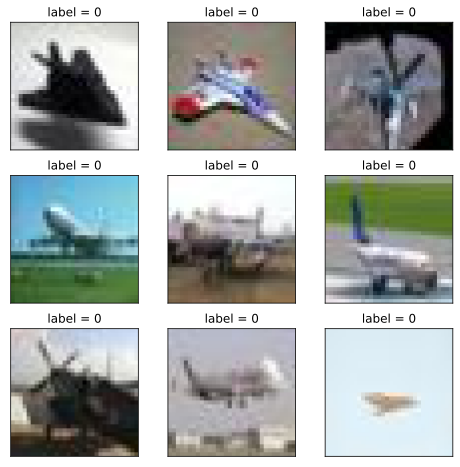

In [38]:
import torch 
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets 
transform_train = transforms.Compose(
    [transforms.ToTensor()])
transform_valid = transforms.Compose(
    [transforms.ToTensor()])
ds_train = datasets.ImageFolder('./eat_pytorch_in_20_days/data/cifar2/train/',
            transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder('./eat_pytorch_in_20_days/data/cifar2/test/',
            transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())

print(ds_train.class_to_idx)
#{'0_airplane': 0, '1_automobile': 1}
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=0)
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=0)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [39]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height
# for x,y in dl_train:
#     print(x.shape,y.shape) 
#     break
#测试AdaptiveMaxPool2d的效果
pool = nn.AdaptiveMaxPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape 

torch.Size([10, 8, 1, 1])

In [40]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [41]:
import torchkeras
torchkeras.summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

模型训练


In [49]:
import pandas as pd 
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred,y_true: roc_auc_score(y_true.data.numpy(),y_pred.data.numpy())
model.metric_name = "auc"

In [50]:
def train_step(model,features,labels):
    
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(),metric.item()

def valid_step(model,features,labels):
    
    # 预测模式，dropout层不发生作用
    model.eval()
    # 关闭梯度计算
    with torch.no_grad():
        predictions = model(features)
        loss = model.loss_func(predictions,labels)
        metric = model.metric_func(predictions,labels)
    
    return loss.item(), metric.item()


# 测试train_step效果
features,labels = next(iter(dl_train))
train_step(model,features,labels)


(0.6975555419921875, 0.4384)

In [51]:
def train_model(model,epochs,dl_train,dl_valid,log_step_freq):

    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)

    for epoch in range(1,epochs+1):  

        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features,labels) in enumerate(dl_train, 1):

            loss,metric = train_step(model,features,labels)

            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:   
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))

        # 2，验证循环-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features,labels) in enumerate(dl_valid, 1):

            val_loss,val_metric = valid_step(model,features,labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum/step, metric_sum/step, 
                val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)

    print('Finished Training...')
    
    return dfhistory

In [52]:
epochs = 20

dfhistory = train_model(model,epochs,dl_train,dl_valid,log_step_freq = 50)

Start Training...
================================================================================2022-03-08 16:08:02
[step = 50] loss: 0.688, auc: 0.662
[step = 100] loss: 0.689, auc: 0.693
[step = 150] loss: 0.687, auc: 0.715
[step = 200] loss: 0.684, auc: 0.728

EPOCH = 1, loss = 0.684,auc  = 0.728, val_loss = 0.670, val_auc = 0.806

================================================================================2022-03-08 16:08:20
[step = 50] loss: 0.668, auc: 0.779
[step = 100] loss: 0.664, auc: 0.783
[step = 150] loss: 0.659, auc: 0.780
[step = 200] loss: 0.653, auc: 0.784

EPOCH = 2, loss = 0.653,auc  = 0.784, val_loss = 0.618, val_auc = 0.825

================================================================================2022-03-08 16:08:37
[step = 50] loss: 0.615, auc: 0.799
[step = 100] loss: 0.606, auc: 0.800
[step = 150] loss: 0.600, auc: 0.797
[step = 200] loss: 0.590, auc: 0.800

EPOCH = 3, loss = 0.590,auc  = 0.800, val_loss = 0.538, val_auc = 0.833

===================

In [53]:
dfhistory 

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.684124,0.728452,0.670023,0.805925
1,2.0,0.652851,0.783915,0.617791,0.824608
2,3.0,0.590217,0.799838,0.537924,0.833191
3,4.0,0.539656,0.808686,0.497850,0.843075
4,5.0,0.518288,0.821457,0.487489,0.856131
5,6.0,0.505792,0.832635,0.466807,0.860463
6,7.0,0.496576,0.838322,0.472085,0.861383
7,8.0,0.488574,0.844582,0.452680,0.869890
8,9.0,0.481429,0.850571,0.449536,0.879274
9,10.0,0.472087,0.860167,0.476963,0.881710


In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

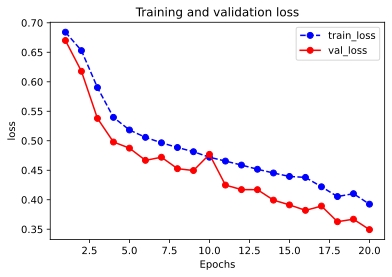

In [55]:
plot_metric(dfhistory,"loss")

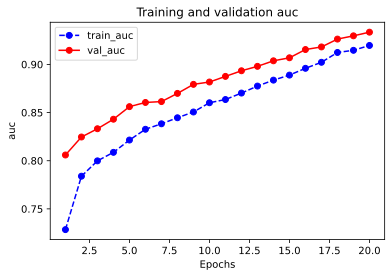

In [56]:
plot_metric(dfhistory,"auc")

In [57]:
def predict(model,dl):
    model.eval()
    with torch.no_grad():
        result = torch.cat([model.forward(t[0]) for t in dl])
    return(result.data)

In [58]:
y_pred_probs = predict(model,dl_valid)
y_pred_probs

tensor([[0.6603],
        [0.8074],
        [0.2091],
        ...,
        [0.0033],
        [0.0327],
        [0.9421]])

In [59]:
y_pred = torch.where(y_pred_probs>0.5,
        torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]])

In [60]:
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])


In [62]:
%pwd

'C:\\Users\\AD\\pytorch'

In [63]:
torch.save(model.state_dict(), "./data/model_parameter.pkl")

net_clone = Net()
net_clone.load_state_dict(torch.load("./data/model_parameter.pkl"))

predict(net_clone,dl_valid)

tensor([[0.0674],
        [0.8618],
        [0.0017],
        ...,
        [0.9166],
        [0.0393],
        [0.6156]])